In [33]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import warnings
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller


In [34]:
data = pd.read_csv("CupIT_Sber_data.csv", delimiter=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091043 entries, 0 to 1091042
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   service_document_id  1091043 non-null  object
 1   account_document_id  1091043 non-null  object
 2   service_date         1091043 non-null  object
 3   service_amount_net   1091043 non-null  object
 4   patient_id           1091043 non-null  object
 5   service_code         1091043 non-null  object
 6   service_name         1091043 non-null  object
 7   is_hospital          1091043 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 66.6+ MB


Извлекаем продукт с наибольшими выплатами

In [45]:
data['service_amount_net'] = pd.to_numeric(data['service_amount_net'], errors='coerce')
product_revenue = data.groupby('service_name')['service_amount_net'].sum()
top_product = product_revenue.idxmax()

top_product_df = data[data['service_name'] == top_product]

print(f"Продукт с наибольшим доходом: {top_product}")
print(f"Общий доход от этого продукта: {product_revenue.max()}")
print(f"\nОтфильтрованные данные:")
top_product_df

Продукт с наибольшим доходом: 0x95758EBA87326C4D5DECC8B51A8B9C61
Общий доход от этого продукта: 368955469.0

Отфильтрованные данные:


,service_document_id,account_document_id,service_date,service_amount_net,patient_id,service_code,service_name,is_hospital
0,0xE3A4BED668151E271B6680FE5E8772D6,0xFDD38318ED6FC6EC68131DB6671F100C,2022-01-01 12:07:00,1925.0,0xD2B5A46F0FFF14D5209ED49B6215BDA0,0xCDEA5658E0AD52E1700653CAE2A4928D,0x95758EBA87326C4D5DECC8B51A8B9C61,0
4,0x1FDDAF54CB064A6E27519F2B6DF97B0E,0x5809EF65F6969882A139F7A484B8D95C,2022-01-01 12:27:00,2200.0,0xF599395DBD681B9A446C26F2DB9E0BF2,0xE6EEC1C29E25C790C0088B42F82CBA55,0x95758EBA87326C4D5DECC8B51A8B9C61,0
5,0x9792A4526F5FAFFA2537A6526B6AC23C,0xE02E4412BB1F637FC4CDAFC793C4F7A4,2022-01-01 12:31:00,1720.0,0x0A1FF218569A9829DDA53CBDF9FD12F9,0x129AB4F27EAA6C675A4E116AB616FE48,0x95758EBA87326C4D5DECC8B51A8B9C61,0
7,0x07EA51E045B591DC5FBA5C1E6D7DEA4B,0x04848F8B05C6935CCECC26FB024BDC6E,2022-01-01 12:41:00,1720.0,0x405E158AE7F0523296EB12EECD73CD79,0x82078385014C595F44D63882A268F47A,0x95758EBA87326C4D5DECC8B51A8B9C61,0
8,0x32B405A9613D446FF83E2E73867A1B49,0xBBAF849258EA3A4CE4B58D2C7686775C,2022-01-01 12:55:00,2200.0,0xF599395DBD681B9A446C26F2DB9E0BF2,0x54054703A9278593F2C779D0E128A3A6,0x95758EBA87326C4D5DECC8B51A8B9C61,0
...,...,...,...,...,...,...,...,...
1090934,0x997FEBE783F76A5589D4ED165A0E6102,0xD8FA3DAEC2CC71C491370D4A0E4ABC99,2023-12-31 15:52:00,2942.0,0xB0788F65901E39EBC363781AF473A83B,0xCDEA5658E0AD52E1700653CAE2A4928D,0x95758EBA87326C4D5DECC8B51A8B9C61,0
1090939,0x6163B5D2DE81CBF7AA0627438F9DFB8F,0x552DBD96020A5C8B5D00BAE348D3EBDB,2023-12-31 11:54:00,2233.0,0xC0E1890739E6256927F5920EC3A6F98C,0x332E8D3220A5317B23558A5E79CE00E4,0x95758EBA87326C4D5DECC8B51A8B9C61,0
1090960,0xC0E01922553DBE2883F8A4B2A1A71A9D,0x817C0EB1C8B59159014FA19ECE12D9B3,2023-12-31 16:26:00,2208.0,0x0A565DD3A1C6A7CA18070F008A1CF1E6,0x6443E7A3B46FDE3B0DE769E069CE29EE,0x95758EBA87326C4D5DECC8B51A8B9C61,0
1090965,0x873F7B119E755FC3EDBA365175E5CE76,0xF84B1C394BDE78756F0AF5BFC67914AC,2023-12-31 13:31:00,2208.0,0x1ADE6B5B0D6177427AABF3E69F9C9B14,0x4F8A79924D1B8D817FC07D5B0814052F,0x95758EBA87326C4D5DECC8B51A8B9C61,0


In [36]:
warnings.filterwarnings('ignore')

# Преобразование данных и агрегация по месяцам
data['service_date'] = pd.to_datetime(data['service_date'])
data.set_index('service_date', inplace=True)

# Конвертация в месячные данные
monthly_data = data['service_amount_net'].resample('M').sum()

In [37]:
def remove_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]

clean_data = remove_outliers_iqr(monthly_data)

In [38]:
def remove_outliers_rolling(series, window=12, threshold=3):
    median = series.rolling(window=window, center=True).median()
    mad = np.abs(series - median).rolling(window=window, center=True).median()
    modified_z_score = 0.6745 * (series - median) / mad
    return series[np.abs(modified_z_score) < threshold]

clean_data = remove_outliers_rolling(monthly_data)

### STL-декомпозиция + обработка остатков

In [39]:
from statsmodels.tsa.seasonal import STL

def remove_outliers_stl(series, seasonal_period=12):
    stl = STL(series, period=seasonal_period, robust=True)
    res = stl.fit()
    residuals = res.resid
    q1 = residuals.quantile(0.25)
    q3 = residuals.quantile(0.75)
    iqr = q3 - q1
    mask = (residuals >= q1 - 3*iqr) & (residuals <= q3 + 3*iqr)
    return series[mask]

clean_data = remove_outliers_stl(monthly_data)

### Визуализация изменений

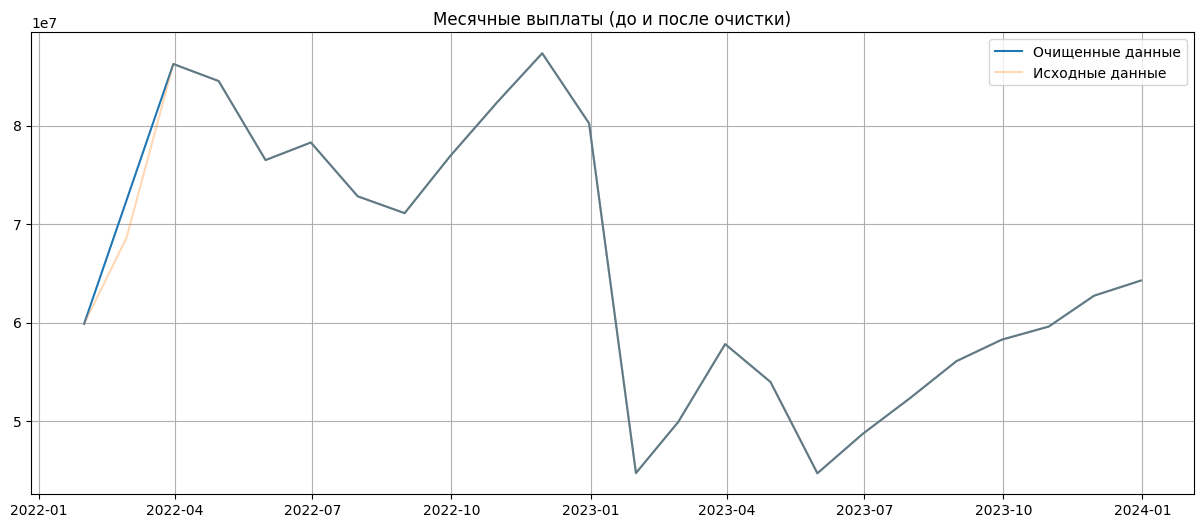

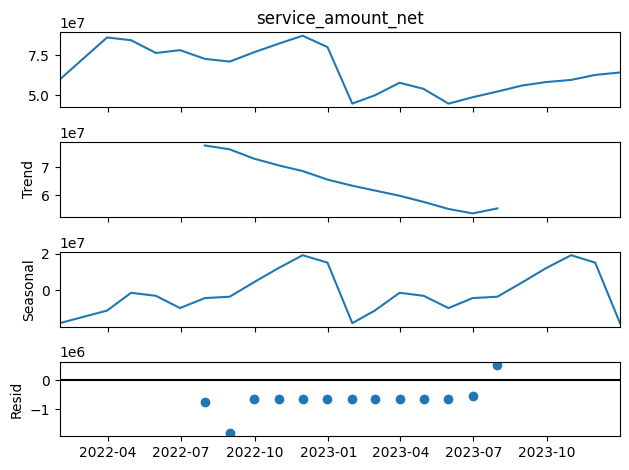

In [40]:
plt.figure(figsize=(15, 6))
plt.plot(clean_data, label='Очищенные данные')
plt.plot(monthly_data, alpha=0.3, label='Исходные данные')
plt.title('Месячные выплаты (до и после очистки)')
plt.legend()
plt.grid()
plt.show()

# Разложение временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(clean_data.dropna(), period=11)
decomposition.plot()
plt.show()

### Проверка стационарности преобразования

In [41]:
def test_stationarity(timeseries):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {dftest[0]}')
    print(f'p-value: {dftest[1]}')
    print('Критические значения:')
    for key, value in dftest[4].items():
        print(f'   {key}: {value}')

test_stationarity(clean_data)

# При необходимости - сезонное дифференцирование
if adfuller(clean_data.dropna())[1] > 0.05:
    clean_data = clean_data.diff(12).dropna()
    test_stationarity(clean_data)

Результаты теста Дики-Фуллера:
ADF Statistic: -1.8665214368695082
p-value: 0.3479706012067614
Критические значения:
   1%: -3.769732625845229
   5%: -3.005425537190083
   10%: -2.6425009917355373
Результаты теста Дики-Фуллера:
ADF Statistic: -1.3819384343727126
p-value: 0.5909037797034169
Критические значения:
   1%: -4.6651863281249994
   5%: -3.3671868750000002
   10%: -2.802960625


Вывод: ряд не стационарный

### H1.1 Предсказание выплат по отдельно взятым продуктам

1. Загрузка и подготовка данных...

2. Анализ и фильтрация данных...
Продукт с наибольшим доходом: 0x95758EBA87326C4D5DECC8B51A8B9C61
Общий доход от этого продукта: 368955469.00

3. Агрегация по месяцам...

Статистика месячных данных:
            revenue
count  2.400000e+01
mean   1.537314e+07
std    3.946083e+06
min    9.672963e+06
25%    1.171815e+07
50%    1.511142e+07
75%    1.875983e+07
max    2.147455e+07

4. Визуализация данных...


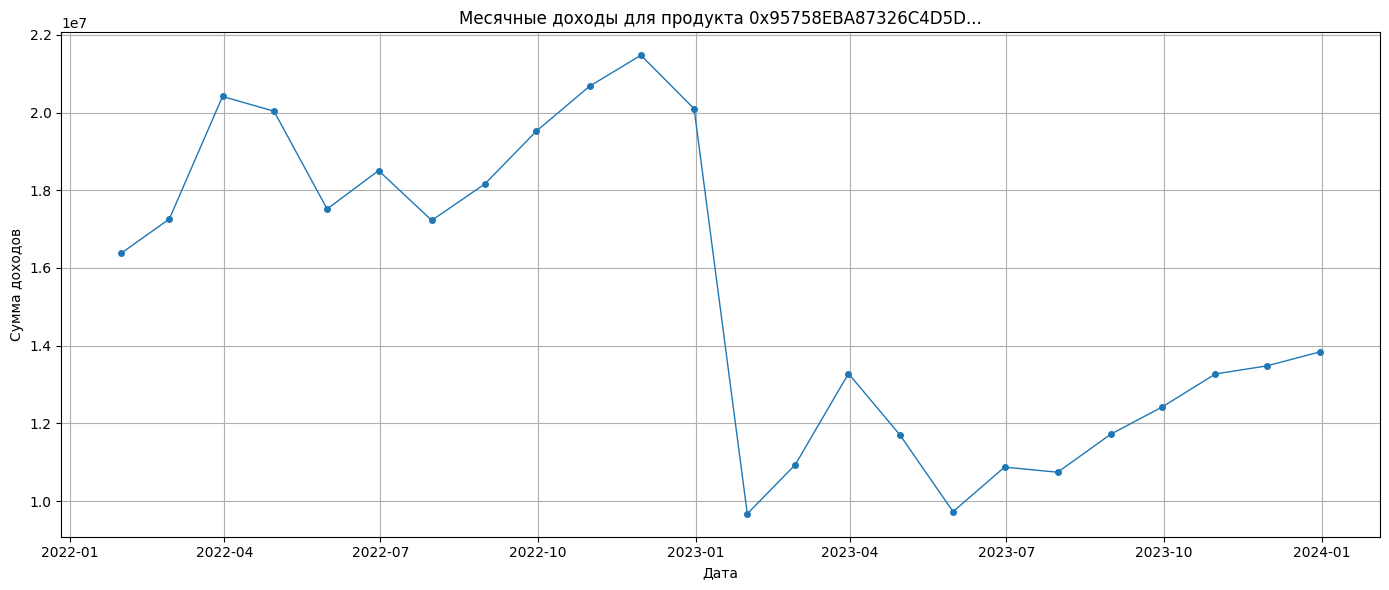


5. Проверка стационарности...
Результаты теста Дики-Фуллера:
ADF Statistic: -1.5685
p-value: 0.4994
Критические значения:
   1%: -3.7529
   5%: -2.9985
   10%: -2.6390

6. Подготовка данных для моделирования...
Размер обучающей выборки: 19 месяцев
Размер тестовой выборки: 5 месяцев

7. Построение SARIMA модели...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=3.02 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=212.107, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=214.044, Time=0.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=215.617, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=247.994, Time=0.00 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=214.092, Time=0.06 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=214.099, Time=0.02 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=214.237, Time=0.14 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=294.080, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=213.784,

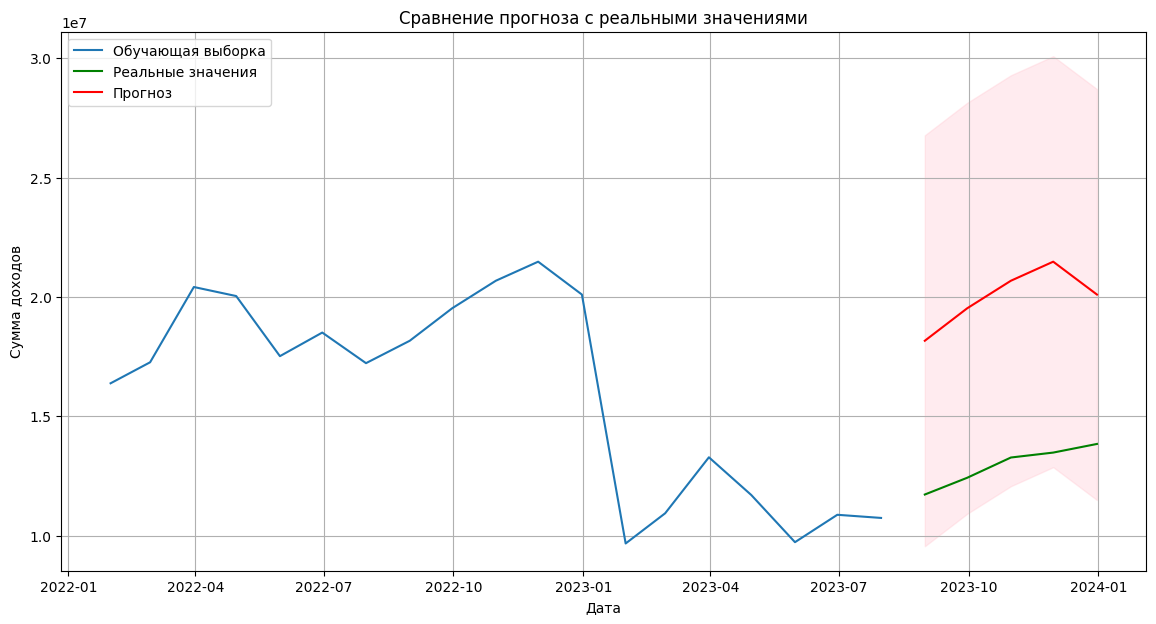


Метрики качества прогноза:
MAE: 7038291.80
RMSE: 7066946.22
MAPE: 54.47%

9. Прогноз на будущие периоды...


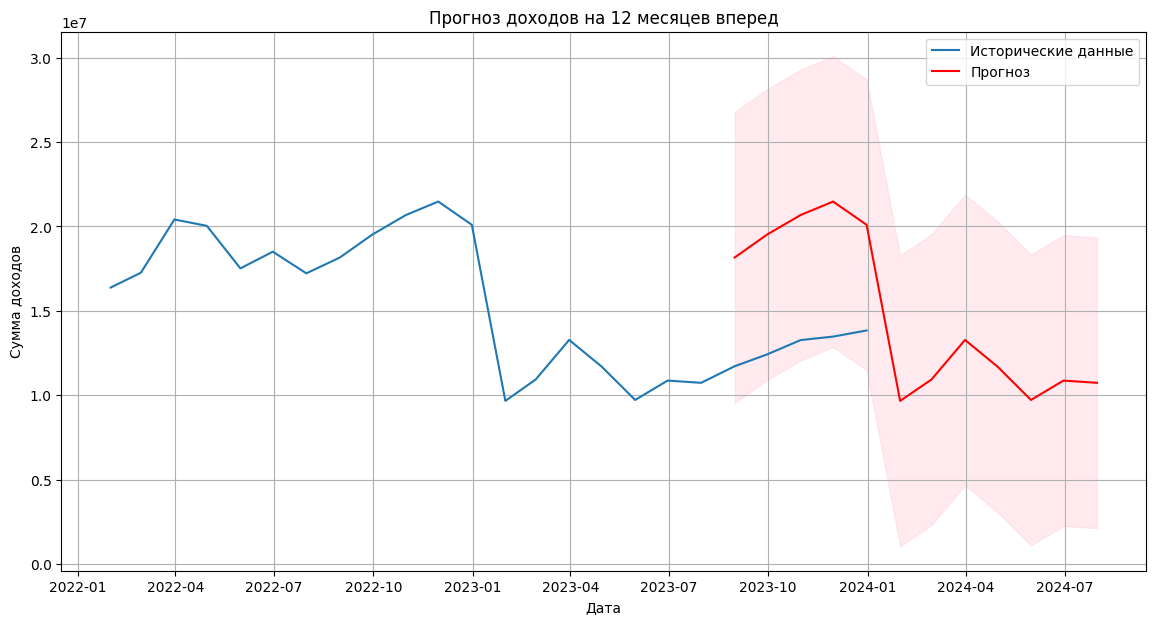


Прогноз сохранен в product_revenue_forecast.csv


In [ ]:
warnings.filterwarnings('ignore')

# 1. Загрузка и подготовка данных
print("1. Загрузка и подготовка данных...")
data = pd.read_csv("CupIT_Sber_data.csv", delimiter=";")

# Преобразование типов данных
data['service_amount_net'] = pd.to_numeric(data['service_amount_net'], errors='coerce')
data['service_date'] = pd.to_datetime(data['service_date'])

# 2. Анализ и фильтрация по продукту
print("\n2. Анализ и фильтрация данных...")
product_revenue = data.groupby('service_name')['service_amount_net'].sum()
top_product = product_revenue.idxmax()
top_product_revenue = product_revenue.max()

print(f"Продукт с наибольшим доходом: {top_product}")
print(f"Общий доход от этого продукта: {top_product_revenue:.2f}")

# Фильтрация данных по топовому продукту
filtered_data = data[data['service_name'] == top_product].copy()

# 3. Агрегация по месяцам и обработка
print("\n3. Агрегация по месяцам...")
monthly_data = filtered_data.resample('M', on='service_date')['service_amount_net'].sum()
monthly_data = monthly_data.to_frame(name='revenue')

# Заполнение пропусков и проверка
monthly_data['revenue'] = monthly_data['revenue'].fillna(method='ffill').fillna(method='bfill')

print(f"\nСтатистика месячных данных:")
print(monthly_data.describe())

# 4. Визуализация временного ряда
print("\n4. Визуализация данных...")
plt.figure(figsize=(14, 6))
plt.plot(monthly_data.index, monthly_data['revenue'], 
         marker='o', linestyle='-', linewidth=1, markersize=4)
plt.title(f'Месячные доходы для продукта {str(top_product)[:20]}...')
plt.xlabel('Дата')
plt.ylabel('Сумма доходов')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Проверка стационарности
print("\n5. Проверка стационарности...")
def test_stationarity(series):
    print('Результаты теста Дики-Фуллера:')
    dftest = adfuller(series.dropna())
    print(f'ADF Statistic: {dftest[0]:.4f}')
    print(f'p-value: {dftest[1]:.4f}')
    print('Критические значения:')
    for key, value in dftest[4].items():
        print(f'   {key}: {value:.4f}')
    return dftest[1] < 0.05

is_stationary = test_stationarity(monthly_data['revenue'])

# 6. Подготовка данных для моделирования
print("\n6. Подготовка данных для моделирования...")
train_size = int(len(monthly_data) * 0.8)
train = monthly_data.iloc[:train_size]
test = monthly_data.iloc[train_size:]

print(f"Размер обучающей выборки: {len(train)} месяцев")
print(f"Размер тестовой выборки: {len(test)} месяцев")

# 7. Построение SARIMA модели
print("\n7. Построение SARIMA модели...")
try:
    # Автоматический подбор параметров
    model = pm.auto_arima(train['revenue'],
                         seasonal=True,
                         m=12,
                         stepwise=True,
                         suppress_warnings=True,
                         error_action='ignore',
                         trace=True,
                         n_fits=10)
    
    print("\nЛучшие параметры модели:")
    print(f"order: {model.order}")
    print(f"seasonal_order: {model.seasonal_order}")
    
    # Обучение финальной модели
    final_model = SARIMAX(train['revenue'],
                        order=model.order,
                        seasonal_order=model.seasonal_order,
                        enforce_stationarity=False)
    results = final_model.fit(disp=False)
    
    print("\nРезультаты обучения модели:")
    print(results.summary())
    
    # 8. Прогнозирование и оценка
    print("\n8. Прогнозирование и оценка...")
    forecast = results.get_forecast(steps=len(test))
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Визуализация прогноза
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train['revenue'], label='Обучающая выборка')
    plt.plot(test.index, test['revenue'], label='Реальные значения', color='green')
    plt.plot(forecast_mean.index, forecast_mean, label='Прогноз', color='red')
    plt.fill_between(conf_int.index,
                    conf_int.iloc[:, 0],
                    conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title('Сравнение прогноза с реальными значениями')
    plt.xlabel('Дата')
    plt.ylabel('Сумма доходов')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Расчет метрик
    mae = mean_absolute_error(test['revenue'], forecast_mean)
    rmse = np.sqrt(mean_squared_error(test['revenue'], forecast_mean))
    mape = np.mean(np.abs((test['revenue'] - forecast_mean) / test['revenue'])) * 100
    
    print("\nМетрики качества прогноза:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    # 9. Прогноз на будущие периоды
    print("\n9. Прогноз на будущие периоды...")
    future_steps = 12
    future_forecast = results.get_forecast(steps=future_steps)
    future_mean = future_forecast.predicted_mean
    future_conf_int = future_forecast.conf_int()
    
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_data.index, monthly_data['revenue'], label='Исторические данные')
    plt.plot(future_mean.index, future_mean, label='Прогноз', color='red')
    plt.fill_between(future_conf_int.index,
                    future_conf_int.iloc[:, 0],
                    future_conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'Прогноз доходов на {future_steps} месяцев вперед')
    plt.xlabel('Дата')
    plt.ylabel('Сумма доходов')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 10. Сохранение результатов
    forecast_df = pd.DataFrame({
        'date': future_mean.index,
        'forecast': future_mean.values,
        'lower_ci': future_conf_int.iloc[:, 0],
        'upper_ci': future_conf_int.iloc[:, 1]
    })
    
    forecast_df.to_csv('product_revenue_forecast.csv', index=False)
    print("\nПрогноз сохранен в product_revenue_forecast.csv")
    
except Exception as e:
    print(f"\nОшибка при построении SARIMA модели: {str(e)}")
    print("Используем простое экспоненциальное сглаживание...")
    
    from statsmodels.tsa.holtwinters import SimpleExpSmoothing
    
    model = SimpleExpSmoothing(train['revenue']).fit()
    forecast_mean = model.forecast(len(test))
    
    # Визуализация
    plt.figure(figsize=(14, 7))
    plt.plot(train.index, train['revenue'], label='Обучающая выборка')
    plt.plot(test.index, test['revenue'], label='Реальные значения', color='green')
    plt.plot(test.index, forecast_mean, label='Прогноз (эксп. сглаживание)', color='red')
    plt.title('Прогноз с использованием экспоненциального сглаживания')
    plt.xlabel('Дата')
    plt.ylabel('Сумма доходов')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    mae = mean_absolute_error(test['revenue'], forecast_mean)
    print(f"\nMAE: {mae:.2f}")

Вывод: прогнозирование по отдельно взятым продуктам происходит с существенной относительной ошибкой. Кроме того, согласно результатам EDA в нашей выборке продуктов содержатся примеры с различными датами запуска и окончания, что усложняет прогнозирование, дальнейшую агрегацию результата и интерепретируемость.

### H1.2 Предсказание выплат по агрегированному ряду всех продуктов

1. Загрузка и подготовка данных...

2. Агрегация данных по месяцам...


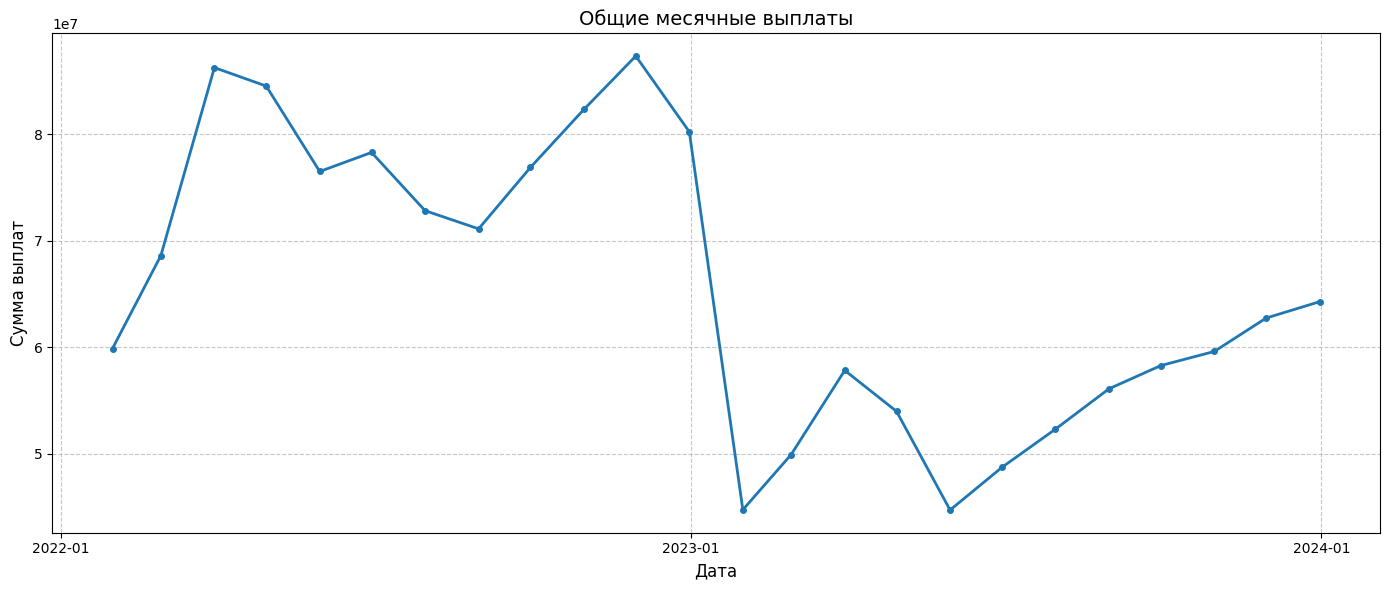


3. Анализ стационарности временного ряда...
ADF Statistic: -1.7719
p-value: 0.3945
Критические значения:
   1%: -3.7529
   5%: -2.9985
   10%: -2.6390

Размеры выборок:
Обучающая: 19 месяцев (2022-01-31 00:00:00 - 2023-07-31 00:00:00)
Тестовая: 5 месяцев (2023-08-31 00:00:00 - 2023-12-31 00:00:00)

5. Подбор гиперпараметров SARIMA...

6. Оценка лучшей модели...

Топ-5 моделей по MAE:
                params           mae          rmse      mape         aic
37  (0, 1, 1, 1, 0, 1)  2.260942e+06  2.552676e+06  3.693340  145.159453
33  (0, 1, 1, 0, 0, 1)  2.307435e+06  2.784135e+06  3.798580  143.503116
34  (0, 1, 1, 0, 1, 0)  3.274473e+06  3.812449e+06  5.402502  138.263224
44  (0, 1, 2, 1, 0, 0)  3.365310e+06  4.058117e+06  5.577632  214.916823
58  (1, 0, 1, 0, 1, 0)  3.512816e+06  3.922531e+06  5.840379  177.119885

Лучшие параметры: order=(0, 1, 1), seasonal_order=(1, 0, 1)
                                     SARIMAX Results                                      
Dep. Variable:        

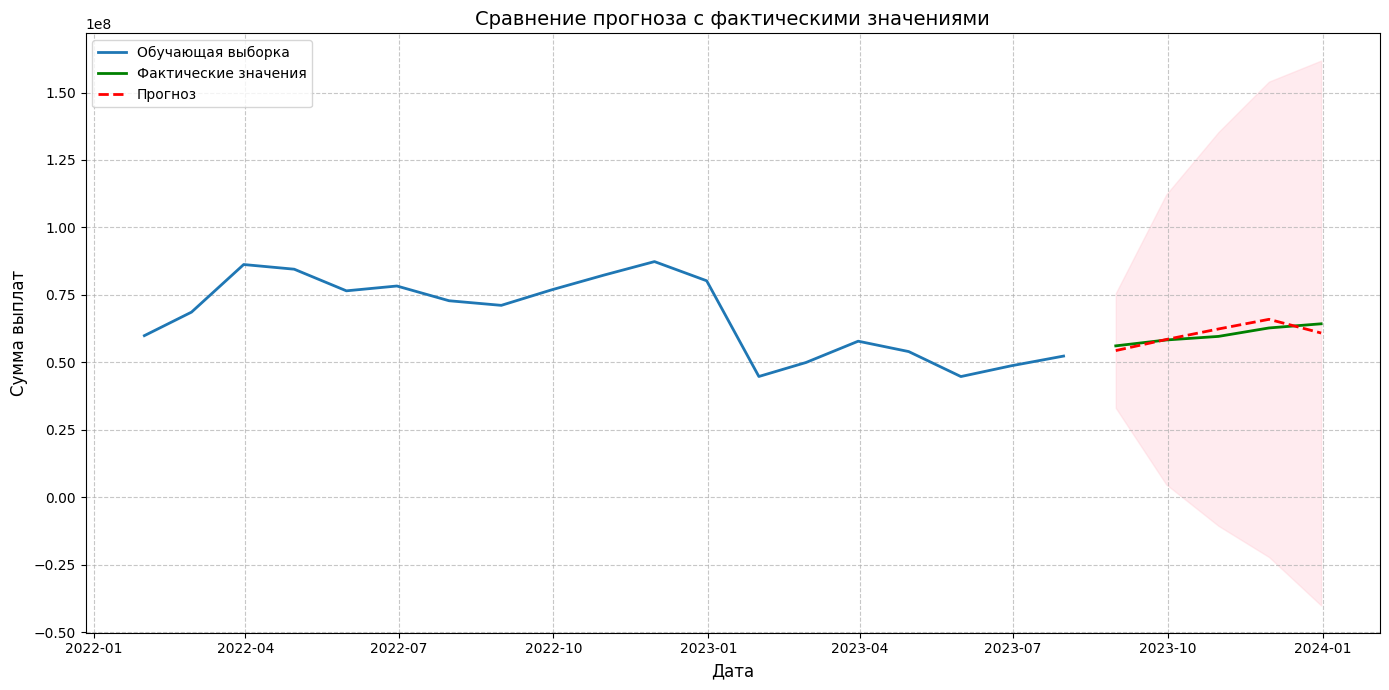


Метрики качества на тестовой выборке:
MAE: 2260942.26
RMSE: 2552675.62
MAPE: 3.69%


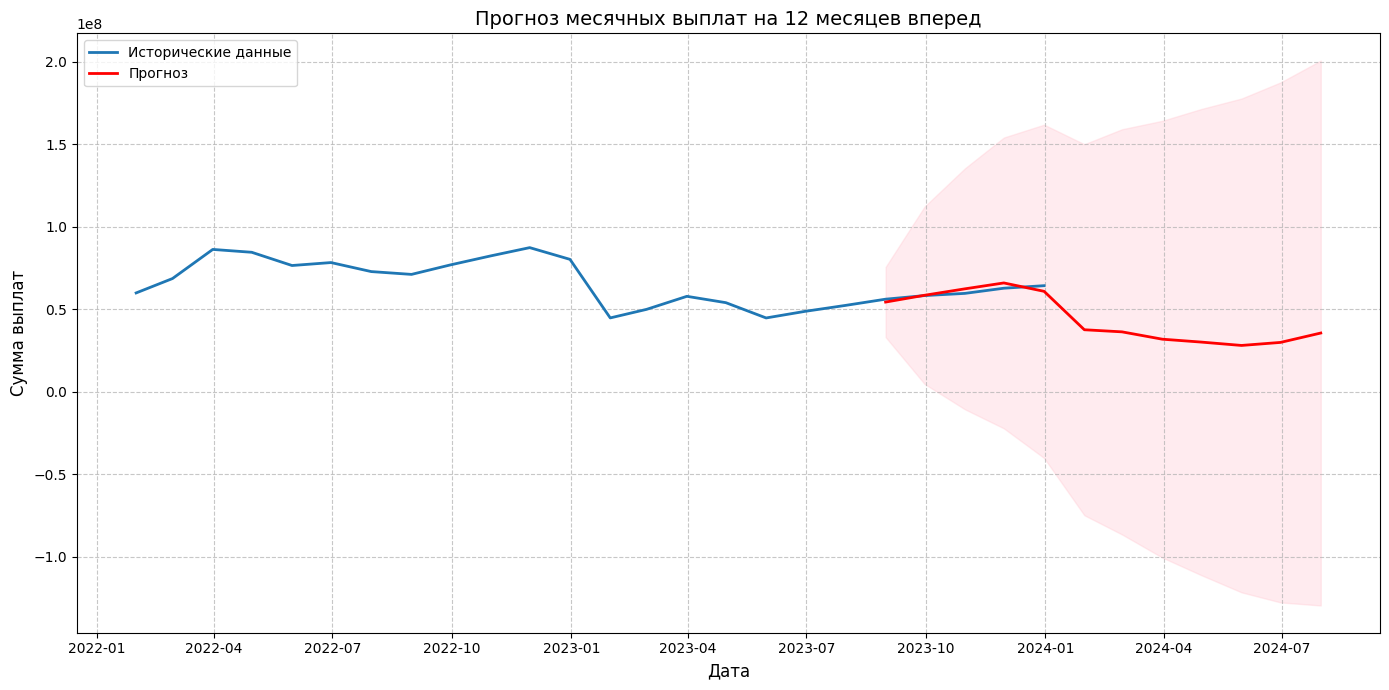


Прогноз сохранен в monthly_payments_forecast.csv


In [43]:
warnings.filterwarnings('ignore')

# 1. Загрузка и подготовка данных
print("1. Загрузка и подготовка данных...")
data = pd.read_csv("CupIT_Sber_data.csv", delimiter=";")

# Преобразование и очистка данных
data['service_amount_net'] = pd.to_numeric(data['service_amount_net'], errors='coerce')
data['service_date'] = pd.to_datetime(data['service_date'])
data = data.dropna(subset=['service_date', 'service_amount_net'])

# 2. Агрегация по месяцам
print("\n2. Агрегация данных по месяцам...")
monthly_data = data.resample('M', on='service_date')['service_amount_net'].sum().to_frame('total_payments')
monthly_data = monthly_data[monthly_data['total_payments'] > 0]  # Удаляем нулевые месяцы

# Визуализация ряда
plt.figure(figsize=(14, 6))
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(monthly_data.index, monthly_data['total_payments'], 
         linewidth=2, marker='o', markersize=4)
plt.title('Общие месячные выплаты', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма выплат', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Анализ стационарности
print("\n3. Анализ стационарности временного ряда...")
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Критические значения:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    return result[1] < 0.05

is_stationary = check_stationarity(monthly_data['total_payments'])

# 4. Подготовка данных для моделирования
train_size = int(len(monthly_data) * 0.8)
train, test = monthly_data.iloc[:train_size], monthly_data.iloc[train_size:]

print(f"\nРазмеры выборок:")
print(f"Обучающая: {len(train)} месяцев ({train.index.min()} - {train.index.max()})")
print(f"Тестовая: {len(test)} месяцев ({test.index.min()} - {test.index.max()})")

# 5. Расширенный подбор гиперпараметров SARIMA
print("\n5. Подбор гиперпараметров SARIMA...")
seasonal_period = 12  # Месячная сезонность

# Параметры для поиска
sarima_params = {
    'p': [0, 1, 2],
    'd': [0, 1],
    'q': [0, 1, 2],
    'P': [0, 1],
    'D': [0, 1],
    'Q': [0, 1],
    'm': [seasonal_period]
}

best_model = None
best_mae = float('inf')
best_params = None

# Метрики для сравнения моделей
metrics = []

for p in sarima_params['p']:
    for d in sarima_params['d']:
        for q in sarima_params['q']:
            for P in sarima_params['P']:
                for D in sarima_params['D']:
                    for Q in sarima_params['Q']:
                        try:
                            model = SARIMAX(train['total_payments'],
                                          order=(p, d, q),
                                          seasonal_order=(P, D, Q, seasonal_period),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
                            
                            results = model.fit(disp=False, maxiter=100)
                            forecast = results.get_forecast(steps=len(test))
                            forecast_mean = forecast.predicted_mean
                            
                            # Расчет метрик
                            mae = mean_absolute_error(test['total_payments'], forecast_mean)
                            rmse = np.sqrt(mean_squared_error(test['total_payments'], forecast_mean))
                            mape = np.mean(np.abs((test['total_payments'] - forecast_mean) / test['total_payments'])) * 100
                            
                            metrics.append({
                                'params': (p, d, q, P, D, Q),
                                'mae': mae,
                                'rmse': rmse,
                                'mape': mape,
                                'aic': results.aic
                            })
                            
                            if mae < best_mae:
                                best_mae = mae
                                best_model = results
                                best_params = (p, d, q, P, D, Q)
                                
                        except Exception as e:
                            continue

# 6. Оценка лучшей модели
print("\n6. Оценка лучшей модели...")
metrics_df = pd.DataFrame(metrics).sort_values('mae')
print("\nТоп-5 моделей по MAE:")
print(metrics_df.head(5))

print(f"\nЛучшие параметры: order={best_params[:3]}, seasonal_order={best_params[3:]}")
print(best_model.summary())

# Прогнозирование на тестовой выборке
forecast = best_model.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# 7. Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['total_payments'], label='Обучающая выборка', linewidth=2)
plt.plot(test.index, test['total_payments'], label='Фактические значения', 
         color='green', linewidth=2)
plt.plot(forecast_mean.index, forecast_mean, label='Прогноз', 
         color='red', linestyle='--', linewidth=2)
plt.fill_between(conf_int.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Сравнение прогноза с фактическими значениями', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма выплат', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 8. Расчет метрик качества
mae = mean_absolute_error(test['total_payments'], forecast_mean)
rmse = np.sqrt(mean_squared_error(test['total_payments'], forecast_mean))
mape = np.mean(np.abs((test['total_payments'] - forecast_mean) / test['total_payments'])) * 100

print("\nМетрики качества на тестовой выборке:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# 9. Прогноз на будущие периоды
future_steps = 12
future_forecast = best_model.get_forecast(steps=future_steps)
future_mean = future_forecast.predicted_mean
future_conf_int = future_forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data['total_payments'], 
         label='Исторические данные', linewidth=2)
plt.plot(future_mean.index, future_mean, 
         label='Прогноз', color='red', linewidth=2)
plt.fill_between(future_conf_int.index,
                future_conf_int.iloc[:, 0],
                future_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f'Прогноз месячных выплат на {future_steps} месяцев вперед', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма выплат', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 10. Сохранение результатов
forecast_df = pd.DataFrame({
    'date': future_mean.index,
    'forecast': future_mean.values,
    'lower_ci': future_conf_int.iloc[:, 0],
    'upper_ci': future_conf_int.iloc[:, 1]
})

forecast_df.to_csv('monthly_payments_forecast.csv', index=False)
print("\nПрогноз сохранен в monthly_payments_forecast.csv")

**Вывод:** получили низкую относительную ошибку. Попробуем выполнить пайплайн, который выполняет обратное преобразование предсказанных результатов

Добавим обратное преобразование

1. Загрузка и подготовка данных...

2. Агрегация данных по месяцам...

4. Подбор параметров модели...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-10.743, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-8.618, Time=0.48 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-10.982, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=9.330, Time=0.00 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=-12.974, Time=0.08 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=-10.973, Time=0.19 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=-8.967, Time=1.63 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=-11.304, Time=0.96 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=-11.444, Time=0.64 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-10.604, Time=0.04 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=inf, Time=0.31 sec

Best model:  ARIMA(0,0,1)(0,1,0)[12] intercept
Total fit time: 6.120 secon

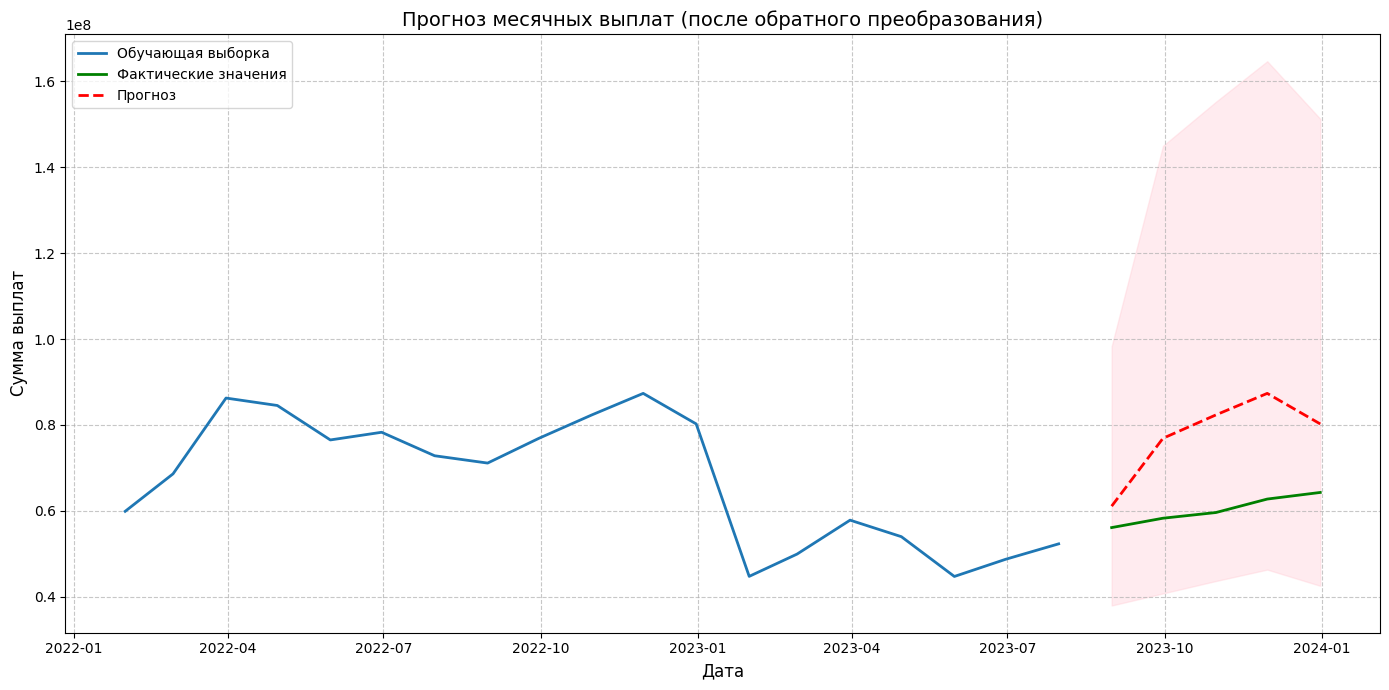


Метрики качества на тестовой выборке:
MAE: 17367889.96
RMSE: 18685653.66
MAPE: 28.58%


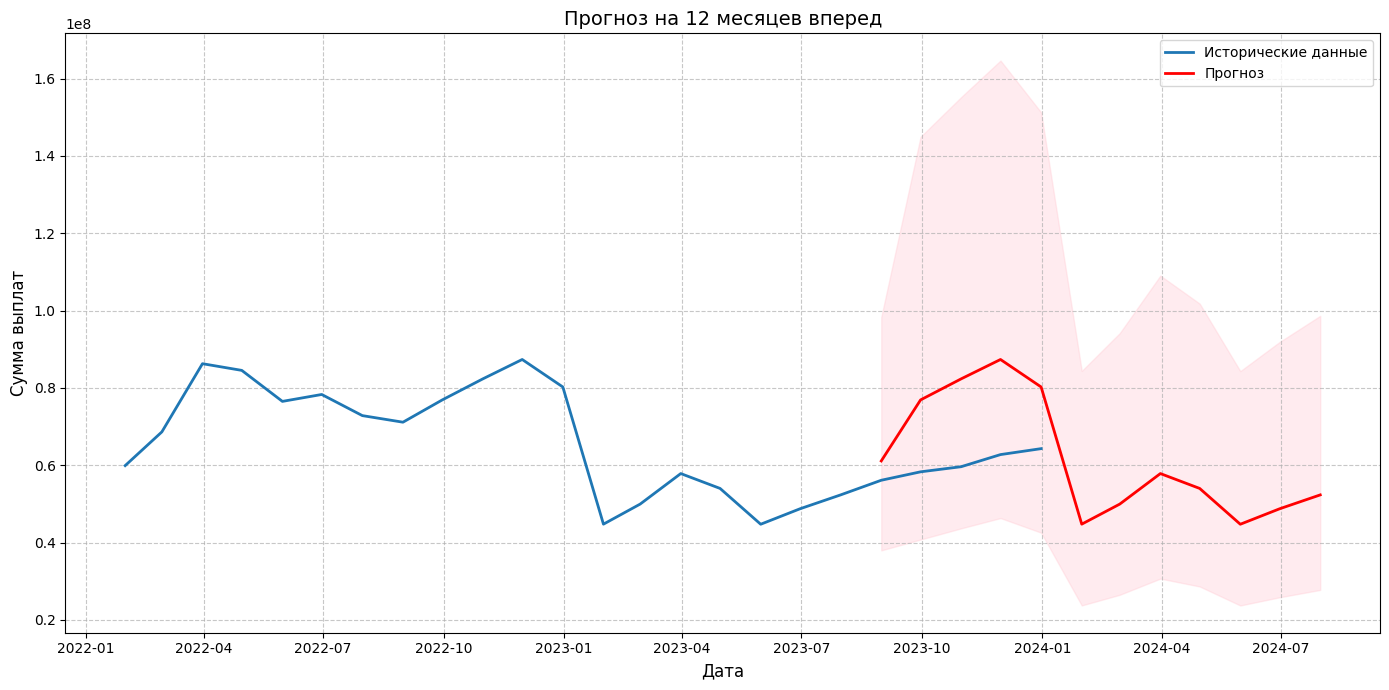


11. Диагностика модели (если возможно)...
Диагностика не доступна: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.
Рекомендация: увеличьте размер обучающей выборки


<Figure size 1500x1000 with 0 Axes>

In [44]:
warnings.filterwarnings('ignore')

# 1. Загрузка и подготовка данных
print("1. Загрузка и подготовка данных...")
data = pd.read_csv("CupIT_Sber_data.csv", delimiter=";")

# Преобразование и очистка данных
data['service_amount_net'] = pd.to_numeric(data['service_amount_net'], errors='coerce')
data['service_date'] = pd.to_datetime(data['service_date'])
data = data.dropna(subset=['service_date', 'service_amount_net'])

# 2. Агрегация по месяцам и логарифмирование
print("\n2. Агрегация данных по месяцам...")
monthly_data = data.resample('M', on='service_date')['service_amount_net'].sum().to_frame('total_payments')
monthly_data = monthly_data[monthly_data['total_payments'] > 0]

# Логарифмирование для стабилизации дисперсии
monthly_data['log_payments'] = np.log(monthly_data['total_payments'])

# 3. Подготовка train/test
train_size = int(len(monthly_data) * 0.8)
train, test = monthly_data.iloc[:train_size], monthly_data.iloc[train_size:]

# 4. Подбор параметров SARIMA с auto_arima
print("\n4. Подбор параметров модели...")
model = auto_arima(train['log_payments'],
                  seasonal=True,
                  m=12,
                  start_p=0, max_p=3,
                  start_q=0, max_q=3,
                  d=None,
                  start_P=0, max_P=2,
                  start_Q=0, max_Q=2,
                  D=None,
                  trace=True,
                  error_action='ignore',
                  suppress_warnings=True,
                  stepwise=True)

print(f"\nЛучшие параметры: order={model.order}, seasonal_order={model.seasonal_order}")

# 5. Обучение модели
final_model = SARIMAX(train['log_payments'],
                     order=model.order,
                     seasonal_order=model.seasonal_order,
                     enforce_stationarity=False)
results = final_model.fit(disp=False)

# 6. Прогнозирование на тестовой выборке
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Обратное преобразование из логарифма
test['forecast'] = np.exp(forecast_mean)
test['lower_ci'] = np.exp(conf_int.iloc[:, 0])
test['upper_ci'] = np.exp(conf_int.iloc[:, 1])

# 7. Визуализация с обратным преобразованием
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['total_payments'], label='Обучающая выборка', linewidth=2)
plt.plot(test.index, test['total_payments'], label='Фактические значения', 
        color='green', linewidth=2)
plt.plot(test.index, test['forecast'], label='Прогноз', 
        color='red', linestyle='--', linewidth=2)
plt.fill_between(test.index,
                test['lower_ci'],
                test['upper_ci'], color='pink', alpha=0.3)
plt.title('Прогноз месячных выплат (после обратного преобразования)', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма выплат', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 8. Расчет метрик на преобразованных данных
mae = mean_absolute_error(test['total_payments'], test['forecast'])
rmse = np.sqrt(mean_squared_error(test['total_payments'], test['forecast']))
mape = np.mean(np.abs((test['total_payments'] - test['forecast']) / test['total_payments'])) * 100

print("\nМетрики качества на тестовой выборке:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# 9. Прогноз на будущие периоды с обратным преобразованием
future_steps = 12
future_forecast = results.get_forecast(steps=future_steps)
future_mean = np.exp(future_forecast.predicted_mean)
future_conf_int = np.exp(future_forecast.conf_int())

plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data['total_payments'], 
        label='Исторические данные', linewidth=2)
plt.plot(future_mean.index, future_mean, 
        label='Прогноз', color='red', linewidth=2)
plt.fill_between(future_conf_int.index,
                future_conf_int.iloc[:, 0],
                future_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title(f'Прогноз на {future_steps} месяцев вперед', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Сумма выплат', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 10. Сохранение прогноза
forecast_df = pd.DataFrame({
    'date': future_mean.index,
    'forecast': future_mean.values,
    'lower_ci': future_conf_int.iloc[:, 0],
    'upper_ci': future_conf_int.iloc[:, 1]
})
forecast_df.to_csv('monthly_payments_forecast.csv', index=False)

# 11. Безопасная диагностика модели
print("\n11. Диагностика модели (если возможно)...")
try:
    results.plot_diagnostics(figsize=(15, 10))
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"Диагностика не доступна: {str(e)}")
    print("Рекомендация: увеличьте размер обучающей выборки")

**Вывод:** относительная ошибка возросла относительно пайплайна на преобразованном временном ряде, однкако результат превосходит гипотезу 1.1